In [3]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, f1_score, roc_auc_score,
                           precision_score, recall_score)

import joblib

Данные будут не номрализованные, так как будут использоваться модели, которым это не требуется, а именно
* Decision Tree

* Random Forest

# Data

In [2]:
print("="*70)
print("БЫСТРАЯ ЗАГРУЗКА И ОПТИМИЗАЦИЯ ДАННЫХ")
print("="*70)

# Загрузка
train_df = pd.read_csv('./data/train_processed.csv')
val_df = pd.read_csv('./data/val_processed.csv')

# Разделение
X_train = train_df.drop(columns=['TARGET'])
y_train = train_df['TARGET']
X_val = val_df.drop(columns=['TARGET'])
y_val = val_df['TARGET']

# Простая оптимизация
print("\nОптимизация типов данных...")

# y в int8
y_train = y_train.astype(np.int8)
y_val = y_val.astype(np.int8)

# Определяем бинарные признаки
binary_cols = []
for col in X_train.columns:
    unique_vals = X_train[col].nunique()
    if unique_vals <= 2 and set(X_train[col].unique()).issubset({0, 1}):
        binary_cols.append(col)
        X_train[col] = X_train[col].astype(np.int8)
        X_val[col] = X_val[col].astype(np.int8)

# Остальные признаки в float32
other_cols = [col for col in X_train.columns if col not in binary_cols]
if other_cols:
    X_train[other_cols] = X_train[other_cols].astype(np.float32)
    X_val[other_cols] = X_val[other_cols].astype(np.float32)

# Результаты
print(f"\nРезультаты:")
print(f"X_train: {X_train.shape}, типы: {X_train.dtypes.unique()}")
print(f"X_val: {X_val.shape}")
print(f"y_train: {y_train.shape}, тип: {y_train.dtype}")
print(f"Бинарных признаков: {len(binary_cols)}")
print(f"Память X_train: {X_train.memory_usage().sum()/1024**2:.1f} MB")

print("\nГотово!")

БЫСТРАЯ ЗАГРУЗКА И ОПТИМИЗАЦИЯ ДАННЫХ

Оптимизация типов данных...

Результаты:
X_train: (184506, 702), типы: [dtype('float32') dtype('int8')]
X_val: (61502, 702)
y_train: (184506,), тип: int8
Бинарных признаков: 115
Память X_train: 433.4 MB

Готово!


# Decision Tree

In [11]:
print("="*70)
print("БЛОК 1: ПОИСК ЛУЧШИХ ГИПЕРПАРАМЕТРОВ ДЛЯ DECISION TREE")
print("="*70)



# 1. Создаем базовую модель
print("\n1. Создание базовой модели DecisionTreeClassifier...")
base_tree = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced'  # Учитываем дисбаланс классов
)

# 2. Определяем сетку гиперпараметров для RandomizedSearchCV
print("\n2. Определение сетки гиперпараметров...")
param_distributions = {
    'criterion': ['gini', 'entropy', 'log_loss'],  # Критерии разделения
    'splitter': ['best', 'random'],                # Стратегия разделения
    'max_depth': [None, 5, 10, 15, 20, 25, 30, 40, 50, 75, 100],  # Глубина дерева
    'min_samples_split': [2, 5, 10, 15, 20, 30, 40, 50],  # Минимальное количество samples для разделения
    'min_samples_leaf': [1, 2, 4, 6, 8, 10, 15, 20, 30], # Минимальное количество samples в листе
    'max_features': ['sqrt', 'log2', None] + list(np.arange(0.1, 1.0, 0.1)),  # Количество признаков для поиска
    'max_leaf_nodes': [None, 10, 20, 30, 40, 50, 75, 100, 150, 200],  # Максимальное количество листьев
    'min_impurity_decrease': [0.0, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1]  # Минимальное уменьшение нечистоты
}

print(f"   Всего параметров для поиска: {sum(len(v) if isinstance(v, list) else 1 for v in param_distributions.values())}")

# 3. Настройка RandomizedSearchCV
print("\n3. Настройка RandomizedSearchCV...")
random_search = RandomizedSearchCV(
    estimator=base_tree,
    param_distributions=param_distributions,
    n_iter=200,           # 50 случайных комбинаций
    cv=3,                # 3 фолда кросс-валидации
    scoring='roc_auc',   # Метрика для оптимизации
    n_jobs=-1,           # Используем все ядра процессора
    verbose=10,          # Детальный вывод прогресса
    random_state=42,
    refit=False,         # Пока не обучаем финальную модель
    return_train_score=True
)

# 4. Запуск поиска гиперпараметров
print("\n4. Запуск поиска лучших гиперпараметров...")
print(f"   Будет проверено {50 * 3} моделей (50 итераций × 3 фолда)")
print(f"   Размер данных: {X_train.shape}")
print("-"*70)

import time
start_time = time.time()
random_search.fit(X_train, y_train)
search_time = time.time() - start_time

# 5. Результаты поиска
print("\n" + "="*70)
print("РЕЗУЛЬТАТЫ ПОИСКА ГИПЕРПАРАМЕТРОВ")
print("="*70)

print(f"Поиск завершен за {search_time/60:.1f} минут")
print(f"\nЛучшие параметры:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nЛучший ROC-AUC на кросс-валидации: {random_search.best_score_:.4f}")

# 6. Показываем топ-5 комбинаций параметров
print("\nТоп-5 лучших комбинаций параметров:")
results_df = pd.DataFrame(random_search.cv_results_)
top_results = results_df.sort_values('mean_test_score', ascending=False).head(5)

for i, (_, row) in enumerate(top_results.iterrows(), 1):
    params = row['params']
    print(f"\n{i}. Score: {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f})")
    print(f"   Параметры: criterion={params.get('criterion')}, max_depth={params.get('max_depth')}, "
          f"min_samples_split={params.get('min_samples_split')}")

# Сохраняем объект random_search для следующего блока
print("\n" + "="*70)
print("ПЕРЕХОД К БЛОКУ 2: ОБУЧЕНИЕ ФИНАЛЬНОЙ МОДЕЛИ")
print("="*70)

БЛОК 1: ПОИСК ЛУЧШИХ ГИПЕРПАРАМЕТРОВ ДЛЯ DECISION TREE

1. Создание базовой модели DecisionTreeClassifier...

2. Определение сетки гиперпараметров...
   Всего параметров для поиска: 62

3. Настройка RandomizedSearchCV...

4. Запуск поиска лучших гиперпараметров...
   Будет проверено 150 моделей (50 итераций × 3 фолда)
   Размер данных: (184506, 702)
----------------------------------------------------------------------
Fitting 3 folds for each of 200 candidates, totalling 600 fits

РЕЗУЛЬТАТЫ ПОИСКА ГИПЕРПАРАМЕТРОВ
Поиск завершен за 19.3 минут

Лучшие параметры:
  splitter: best
  min_samples_split: 50
  min_samples_leaf: 8
  min_impurity_decrease: 0.0
  max_leaf_nodes: 30
  max_features: None
  max_depth: 15
  criterion: log_loss

Лучший ROC-AUC на кросс-валидации: 0.7103

Топ-5 лучших комбинаций параметров:

1. Score: 0.7103 (+/- 0.0039)
   Параметры: criterion=log_loss, max_depth=15, min_samples_split=50

2. Score: 0.7091 (+/- 0.0055)
   Параметры: criterion=gini, max_depth=100, min

In [12]:
print("="*70)
print("БЛОК 2: ОБУЧЕНИЕ ФИНАЛЬНОЙ МОДЕЛИ НА ВСЕХ ДАННЫХ")
print("="*70)

# 1. Извлекаем лучшие параметры
print("\n1. Извлечение лучших параметров из поиска...")
best_params = random_search.best_params_
print(f"Лучшие параметры: {best_params}")

# 2. Создаем финальную модель с лучшими параметрами
print("\n2. Создание финальной модели...")
final_tree = DecisionTreeClassifier(
    **best_params,
    random_state=42,
    class_weight='balanced'
)

# 3. Обучение на всех тренировочных данных
print(f"\n3. Обучение модели на всех {len(X_train)} samples...")
print(f"   Размер данных: {X_train.shape}")

train_start = time.time()
final_tree.fit(X_train, y_train)
train_time = time.time() - train_start

print(f"\nМодель обучена за {train_time:.1f} секунд ({train_time/60:.1f} минут)")

# 4. Сохраняем лучшую модель в переменную best_model
best_model = final_tree
print(f"\n4. Лучшая модель сохранена в переменной 'best_model'")
print(f"   Тип модели: {type(best_model).__name__}")
print(f"   Глубина дерева: {best_model.get_depth()}")
print(f"   Количество листьев: {best_model.get_n_leaves()}")

# 5. Сохранение модели (опционально)
print("\n5. Сохранение обученной модели...")
import joblib

tree_artifacts = {
    'model': best_model,
    'best_params': best_params,
    'cv_score': random_search.best_score_,
    'training_time': train_time,
    'feature_names': list(X_train.columns)
}

joblib.dump(tree_artifacts, './models/decision_tree_best_model.pkl')
print("Модель сохранена в './models/decision_tree_best_model.pkl'")

print("\n" + "="*70)
print("ПЕРЕХОД К БЛОКУ 3: ОЦЕНКА МЕТРИК")
print("="*70)

БЛОК 2: ОБУЧЕНИЕ ФИНАЛЬНОЙ МОДЕЛИ НА ВСЕХ ДАННЫХ

1. Извлечение лучших параметров из поиска...
Лучшие параметры: {'splitter': 'best', 'min_samples_split': 50, 'min_samples_leaf': 8, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 30, 'max_features': None, 'max_depth': 15, 'criterion': 'log_loss'}

2. Создание финальной модели...

3. Обучение модели на всех 184506 samples...
   Размер данных: (184506, 702)

Модель обучена за 20.2 секунд (0.3 минут)

4. Лучшая модель сохранена в переменной 'best_model'
   Тип модели: DecisionTreeClassifier
   Глубина дерева: 7
   Количество листьев: 30

5. Сохранение обученной модели...
Модель сохранена в './models/decision_tree_best_model.pkl'

ПЕРЕХОД К БЛОКУ 3: ОЦЕНКА МЕТРИК


БЛОК 3: ОЦЕНКА МЕТРИК НА ВАЛИДАЦИОННОЙ ВЫБОРКЕ

1. Выполнение предсказаний на валидации...
   Размер валидационных данных: (61502, 702)
   Предсказания выполнены!

2. Расчет метрик...

МЕТРИКИ DECISION TREE НА ВАЛИДАЦИОННОЙ ВЫБОРКЕ

Основные метрики:
  Accuracy:  0.6481
  Precision: 0.5499
  Recall:    0.6583
  F1 Score:  0.5034
  ROC-AUC:   0.7082

------------------------------------------------------------
Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.65      0.77     56537
           1       0.14      0.67      0.24      4965

    accuracy                           0.65     61502
   macro avg       0.55      0.66      0.50     61502
weighted avg       0.89      0.65      0.73     61502


------------------------------------------------------------
Confusion Matrix:
------------------------------------------------------------
[[36530 20007]
 [ 1636  3329]]

Виз

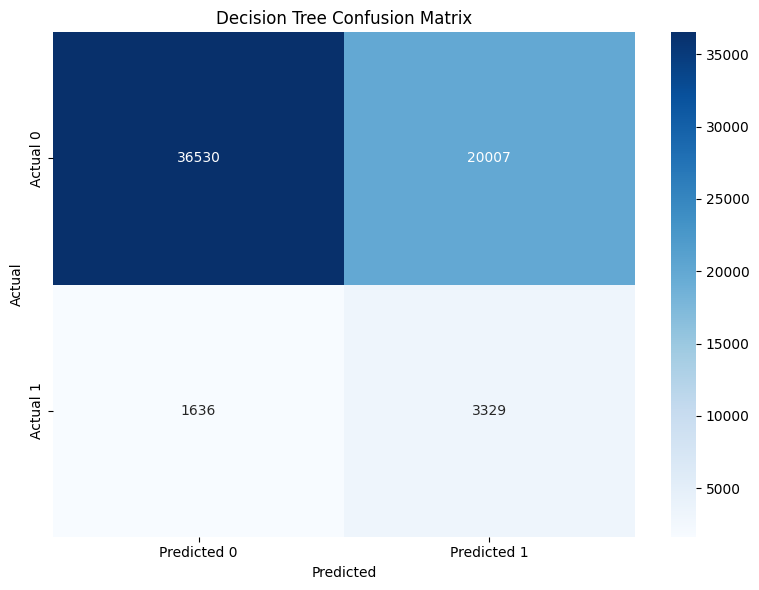


------------------------------------------------------------
ВАЖНОСТЬ ПРИЗНАКОВ (TOP-20)
------------------------------------------------------------

Самые важные признаки:
                                          feature  importance
                                     EXT_SOURCE_3    0.456433
                                     EXT_SOURCE_2    0.364383
         client_installments_AMT_PAYMENT_min_mean    0.041974
          client_installments_AMT_PAYMENT_min_sum    0.024591
                                    CODE_GENDER_F    0.023677
       client_cash_CNT_INSTALMENT_FUTURE_mean_max    0.013544
             NAME_EDUCATION_TYPE_Higher education    0.012782
                                    DAYS_EMPLOYED    0.012052
   client_installments_DAYS_ENTRY_PAYMENT_min_min    0.010004
NAME_EDUCATION_TYPE_Secondary / secondary special    0.009691
          client_installments_AMT_PAYMENT_min_max    0.008674
                         previous_CNT_PAYMENT_max    0.007904
        client_inst

In [13]:
print("="*70)
print("БЛОК 3: ОЦЕНКА МЕТРИК НА ВАЛИДАЦИОННОЙ ВЫБОРКЕ")
print("="*70)


# 1. Предсказания на валидационной выборке
print("\n1. Выполнение предсказаний на валидации...")
print(f"   Размер валидационных данных: {X_val.shape}")

# Predict
y_val_pred = best_model.predict(X_val)

# Predict_proba для ROC-AUC
y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]

print("   Предсказания выполнены!")

# 2. Расчет всех метрик
print("\n2. Расчет метрик...")

accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, average='macro', zero_division=0)
recall = recall_score(y_val, y_val_pred, average='macro', zero_division=0)
f1 = f1_score(y_val, y_val_pred, average='macro', zero_division=0)
roc_auc = roc_auc_score(y_val, y_val_pred_proba)

# 3. Вывод метрик
print("\n" + "="*60)
print("МЕТРИКИ DECISION TREE НА ВАЛИДАЦИОННОЙ ВЫБОРКЕ")
print("="*60)

print(f"\nОсновные метрики:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1 Score:  {f1:.4f}")
print(f"  ROC-AUC:   {roc_auc:.4f}")

# 4. Classification Report
print("\n" + "-"*60)
print("Classification Report:")
print("-"*60)
print(classification_report(y_val, y_val_pred, zero_division=0))

# 5. Confusion Matrix
print("\n" + "-"*60)
print("Confusion Matrix:")
print("-"*60)
cm = confusion_matrix(y_val, y_val_pred)
print(cm)

# Визуализация confusion matrix (опционально)
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    print("\nВизуализация Confusion Matrix...")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title('Decision Tree Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()
except:
    print("Matplotlib/Seaborn не установлены, пропускаю визуализацию")

# 6. Важность признаков
print("\n" + "-"*60)
print("ВАЖНОСТЬ ПРИЗНАКОВ (TOP-20)")
print("-"*60)

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nСамые важные признаки:")
print(feature_importance.head(20).to_string(index=False))

print(f"\nВсего важных признаков (importance > 0): {(feature_importance['importance'] > 0).sum()}")
print(f"Признаков с нулевой важностью: {(feature_importance['importance'] == 0).sum()}")

# 7. Сохранение результатов
print("\n" + "="*60)
print("СОХРАНЕНИЕ РЕЗУЛЬТАТОВ ОЦЕНКИ")
print("="*60)

# Обновляем артефакты с метриками валидации
tree_artifacts['val_metrics'] = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'roc_auc': roc_auc,
    'confusion_matrix': cm.tolist()
}

tree_artifacts['feature_importance'] = feature_importance.to_dict('records')

joblib.dump(tree_artifacts, './models/decision_tree_best_model.pkl')
print("Полные результаты сохранены в './models/decision_tree_best_model.pkl'")

# 8. Итоговая информация
print("\n" + "="*70)
print("ИТОГОВАЯ ИНФОРМАЦИЯ")
print("="*70)

print(f"\nМодель: Decision Tree Classifier")
print(f"Лучший CV ROC-AUC: {random_search.best_score_:.4f}")
print(f"Валидационный ROC-AUC: {roc_auc:.4f}")
print(f"Accuracy на валидации: {accuracy:.4f}")
print(f"F1 Score на валидации: {f1:.4f}")
print(f"\nХарактеристики дерева:")
print(f"  Глубина: {best_model.get_depth()}")
print(f"  Листьев: {best_model.get_n_leaves()}")
print(f"  Важных признаков: {(feature_importance['importance'] > 0).sum()}")

print("\n" + "="*70)
print("DECISION TREE МОДЕЛЬ ОБУЧЕНА И ОЦЕНЕНА!")
print("="*70)

In [12]:
# 1. В начале ноутбука создаем пустой список
model_results = []

# 2. После КАЖДОЙ обученной модели:
def log_model(model, X_val, y_val, name):
    """Записывает метрики модели в таблицу"""
    
    y_pred = model.predict(X_val)
    
    result = {
        'model': name,
        'accuracy': round(accuracy_score(y_val, y_pred), 4),
        'f1': round(f1_score(y_val, y_pred, average='macro'), 4)
    }
    
    # ROC-AUC если доступен
    if hasattr(model, 'predict_proba'):
        try:
            y_proba = model.predict_proba(X_val)
            if len(model.classes_) == 2:
                result['roc_auc'] = round(roc_auc_score(y_val, y_proba[:, 1]), 4)
        except:
            pass
    
    model_results.append(result)
    
    # Создаем DataFrame и показываем
    results_df = pd.concat([pd.read_csv('results.csv'), pd.DataFrame(model_results)], ignore_index=True)
    print(f"\nДобавлена модель: {name}")
    print(results_df.to_string(index=False))
    
    return results_df

In [ ]:

artifacts = joblib.load('./models/decision_tree_best_model.pkl')

results = log_model(artifacts['model'], X_val, y_val, 'DcisionTreeClassifier')
results.to_csv('results.csv', index=False)

# Random forest Classifier

In [4]:
print("="*80)
print("БЛОК 1: ПОИСК ЛУЧШИХ ГИПЕРПАРАМЕТРОВ ДЛЯ RANDOM FOREST")
print("="*80)



# 1. Создаем базовую модель
print("\n1. Создание базовой модели RandomForestClassifier...")
base_rf = RandomForestClassifier(
    random_state=42,
    class_weight='balanced',  # Учитываем дисбаланс классов
    n_jobs=-1,                # Используем все ядра
    verbose=0
)

# 2. Определяем сетку гиперпараметров для RandomizedSearchCV
print("\n2. Определение сетки гиперпараметров...")
param_distributions = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 400, 500],  # Количество деревьев
    'criterion': ['gini', 'entropy', 'log_loss'],             # Критерии разделения
    'max_depth': [None, 10, 20, 30, 40, 50, 75, 100],         # Глубина деревьев
    'min_samples_split': [2, 5, 10, 15, 20],                  # Минимальное количество samples для разделения
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],                  # Минимальное количество samples в листе
    'max_features': ['sqrt', 'log2', None] + list(np.arange(0.1, 1.0, 0.1)),  # Количество признаков
    'bootstrap': [True, False],                               # Использовать ли bootstrap
    'max_samples': [None, 0.5, 0.6, 0.7, 0.8, 0.9],           # Размер подвыборки для каждого дерева
    'min_impurity_decrease': [0.0, 0.001, 0.005, 0.01, 0.02]  # Минимальное уменьшение нечистоты
}

print(f"   Всего параметров для поиска: {sum(len(v) if isinstance(v, list) else 1 for v in param_distributions.values())}")

# 3. Настройка RandomizedSearchCV
print("\n3. Настройка RandomizedSearchCV...")
random_search = RandomizedSearchCV(
    estimator=base_rf,
    param_distributions=param_distributions,
    n_iter=30,           # 30 случайных комбинаций (меньше чем для дерева, т.к. RF медленнее)
    cv=3,                # 3 фолда кросс-валидации
    scoring='roc_auc',   # Метрика для оптимизации
    n_jobs=1,            # RandomForest уже параллелит деревья, тут ставим 1
    verbose=10,          # Детальный вывод прогресса
    random_state=42,
    refit=False,         # Пока не обучаем финальную модель
    return_train_score=True
)

# 4. Запуск поиска гиперпараметров
print("\n4. Запуск поиска лучших гиперпараметров...")
print(f"   Будет проверено {30 * 3} моделей (30 итераций × 3 фолда)")
print(f"   Размер данных: {X_train.shape}")
print(f"   Оценка времени: ~{30 * 3 * 2 / 60:.1f}-{30 * 3 * 5 / 60:.1f} минут (2-5 сек на дерево)")
print("-"*80)

import time
start_time = time.time()
random_search.fit(X_train, y_train)
search_time = time.time() - start_time

# 5. Результаты поиска
print("\n" + "="*80)
print("РЕЗУЛЬТАТЫ ПОИСКА ГИПЕРПАРАМЕТРОВ RANDOM FOREST")
print("="*80)

print(f"Поиск завершен за {search_time/60:.1f} минут")
print(f"\nЛучшие параметры:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nЛучший ROC-AUC на кросс-валидации: {random_search.best_score_:.4f}")

# 6. Показываем топ-5 комбинаций параметров
print("\nТоп-5 лучших комбинаций параметров:")
results_df = pd.DataFrame(random_search.cv_results_)
top_results = results_df.sort_values('mean_test_score', ascending=False).head(5)

for i, (_, row) in enumerate(top_results.iterrows(), 1):
    params = row['params']
    print(f"\n{i}. Score: {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f})")
    print(f"   n_estimators={params.get('n_estimators')}, max_depth={params.get('max_depth')}, "
          f"max_features={params.get('max_features')}")

print("\n" + "="*80)
print("ПЕРЕХОД К БЛОКУ 2: ОБУЧЕНИЕ ФИНАЛЬНОЙ МОДЕЛИ")
print("="*80)

БЛОК 1: ПОИСК ЛУЧШИХ ГИПЕРПАРАМЕТРОВ ДЛЯ RANDOM FOREST

1. Создание базовой модели RandomForestClassifier...

2. Определение сетки гиперпараметров...
   Всего параметров для поиска: 55

3. Настройка RandomizedSearchCV...

4. Запуск поиска лучших гиперпараметров...
   Будет проверено 90 моделей (30 итераций × 3 фолда)
   Размер данных: (184506, 702)
   Оценка времени: ~3.0-7.5 минут (2-5 сек на дерево)
--------------------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV 1/3; 1/30] START bootstrap=False, criterion=gini, max_depth=10, max_features=0.6, max_samples=0.5, min_impurity_decrease=0.001, min_samples_leaf=2, min_samples_split=15, n_estimators=400
[CV 1/3; 1/30] END bootstrap=False, criterion=gini, max_depth=10, max_features=0.6, max_samples=0.5, min_impurity_decrease=0.001, min_samples_leaf=2, min_samples_split=15, n_estimators=400;, score=(train=nan, test=nan) total time=   0.4s
[CV 2/3; 1/30] START boo

In [5]:
print("="*80)
print("БЛОК 2: ОБУЧЕНИЕ ФИНАЛЬНОЙ МОДЕЛИ RANDOM FOREST")
print("="*80)

# 1. Извлекаем лучшие параметры
print("\n1. Извлечение лучших параметров из поиска...")
best_params = random_search.best_params_
print(f"Лучшие параметры:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

# 2. Корректируем параметры для финального обучения
print("\n2. Корректировка параметров для финального обучения...")

# Если n_estimators слишком маленькое, увеличиваем для финальной модели
if 'n_estimators' in best_params and best_params['n_estimators'] < 100:
    best_params['n_estimators'] = min(200, best_params['n_estimators'] * 2)
    print(f"   Увеличиваю n_estimators до {best_params['n_estimators']} для лучшей стабильности")

# 3. Создаем финальную модель с лучшими параметрами
print("\n3. Создание финальной модели RandomForest...")
final_rf = RandomForestClassifier(
    **best_params,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1,           # Используем все ядра для обучения
    verbose=1            # Показываем прогресс обучения
)

# 4. Обучение на всех тренировочных данных
print(f"\n4. Обучение модели на всех {len(X_train)} samples...")
print(f"   Размер данных: {X_train.shape}")
print(f"   Количество деревьев: {best_params.get('n_estimators', 100)}")
print(f"   Начинаю обучение...")

train_start = time.time()
final_rf.fit(X_train, y_train)
train_time = time.time() - train_start

print(f"\nМодель RandomForest обучена за {train_time/60:.1f} минут")
print(f"   Обучено {final_rf.n_estimators} деревьев")

# 5. Сохраняем лучшую модель в переменную best_model
best_model = final_rf
print(f"\n5. Лучшая модель сохранена в переменной 'best_model'")
print(f"   Тип модели: {type(best_model).__name__}")
print(f"   Количество деревьев: {best_model.n_estimators}")

# 6. Сохранение модели (опционально)
print("\n6. Сохранение обученной модели...")
import joblib

rf_artifacts = {
    'model': best_model,
    'best_params': best_params,
    'cv_score': random_search.best_score_,
    'training_time_minutes': train_time / 60,
    'feature_names': list(X_train.columns),
    'model_info': {
        'n_trees': best_model.n_estimators,
        'max_depth': best_model.max_depth,
        'n_features': best_model.n_features_in_,
        'n_classes': best_model.n_classes_
    }
}

joblib.dump(rf_artifacts, './models/random_forest_best_model.pkl')
print("Модель сохранена в './models/random_forest_best_model.pkl'")

print("\n" + "="*80)
print("ПЕРЕХОД К БЛОКУ 3: ОЦЕНКА МЕТРИК")
print("="*80)

БЛОК 2: ОБУЧЕНИЕ ФИНАЛЬНОЙ МОДЕЛИ RANDOM FOREST

1. Извлечение лучших параметров из поиска...
Лучшие параметры:
  n_estimators: 250
  min_samples_split: 10
  min_samples_leaf: 8
  min_impurity_decrease: 0.0
  max_samples: 0.8
  max_features: 0.30000000000000004
  max_depth: None
  criterion: entropy
  bootstrap: True

2. Корректировка параметров для финального обучения...

3. Создание финальной модели RandomForest...

4. Обучение модели на всех 184506 samples...
   Размер данных: (184506, 702)
   Количество деревьев: 250
   Начинаю обучение...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  5.7min finished



Модель RandomForest обучена за 5.7 минут
   Обучено 250 деревьев

5. Лучшая модель сохранена в переменной 'best_model'
   Тип модели: RandomForestClassifier
   Количество деревьев: 250

6. Сохранение обученной модели...
Модель сохранена в './models/random_forest_best_model.pkl'

ПЕРЕХОД К БЛОКУ 3: ОЦЕНКА МЕТРИК


БЛОК 3: ОЦЕНКА МЕТРИК RANDOM FOREST НА ВАЛИДАЦИОННОЙ ВЫБОРКЕ

1. Выполнение предсказаний на валидации...
   Размер валидационных данных: (61502, 702)


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 250 out of 250 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 250 out of 250 | elapsed:    0.4s finished


   Предсказания выполнены!

2. Расчет метрик...

МЕТРИКИ RANDOM FOREST НА ВАЛИДАЦИОННОЙ ВЫБОРКЕ

Основные метрики:
  Accuracy:  0.9171
  Precision: 0.6687
  Recall:    0.5280
  F1 Score:  0.5336
  ROC-AUC:   0.7524

------------------------------------------------------------
Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.99      0.96     56537
           1       0.41      0.06      0.11      4965

    accuracy                           0.92     61502
   macro avg       0.67      0.53      0.53     61502
weighted avg       0.88      0.92      0.89     61502


------------------------------------------------------------
Confusion Matrix:
------------------------------------------------------------
[[56088   449]
 [ 4648   317]]

Визуализация Confusion Matrix...


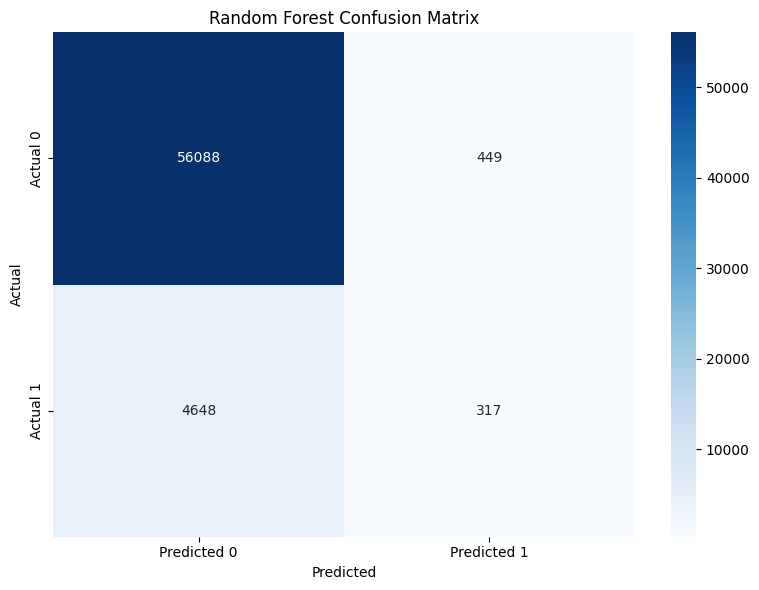


ВАЖНОСТЬ ПРИЗНАКОВ RANDOM FOREST (TOP-30)

Самые важные признаки:
                                 feature  importance
                            EXT_SOURCE_2    0.062301
                            EXT_SOURCE_3    0.055774
                           DAYS_EMPLOYED    0.016036
                              DAYS_BIRTH    0.014167
                             AMT_ANNUITY    0.011515
                              AMT_CREDIT    0.011356
client_installments_AMT_PAYMENT_min_mean    0.011234
 client_installments_AMT_PAYMENT_min_sum    0.011167
                       DAYS_REGISTRATION    0.010002
                         DAYS_ID_PUBLISH    0.009871
                 bureau_DAYS_CREDIT_mean    0.009412
                  bureau_DAYS_CREDIT_max    0.007766
                  DAYS_LAST_PHONE_CHANGE    0.007592
 client_installments_AMT_PAYMENT_min_max    0.007434
              REGION_POPULATION_RELATIVE    0.007055
                              Unnamed: 0    0.006789
                              SK

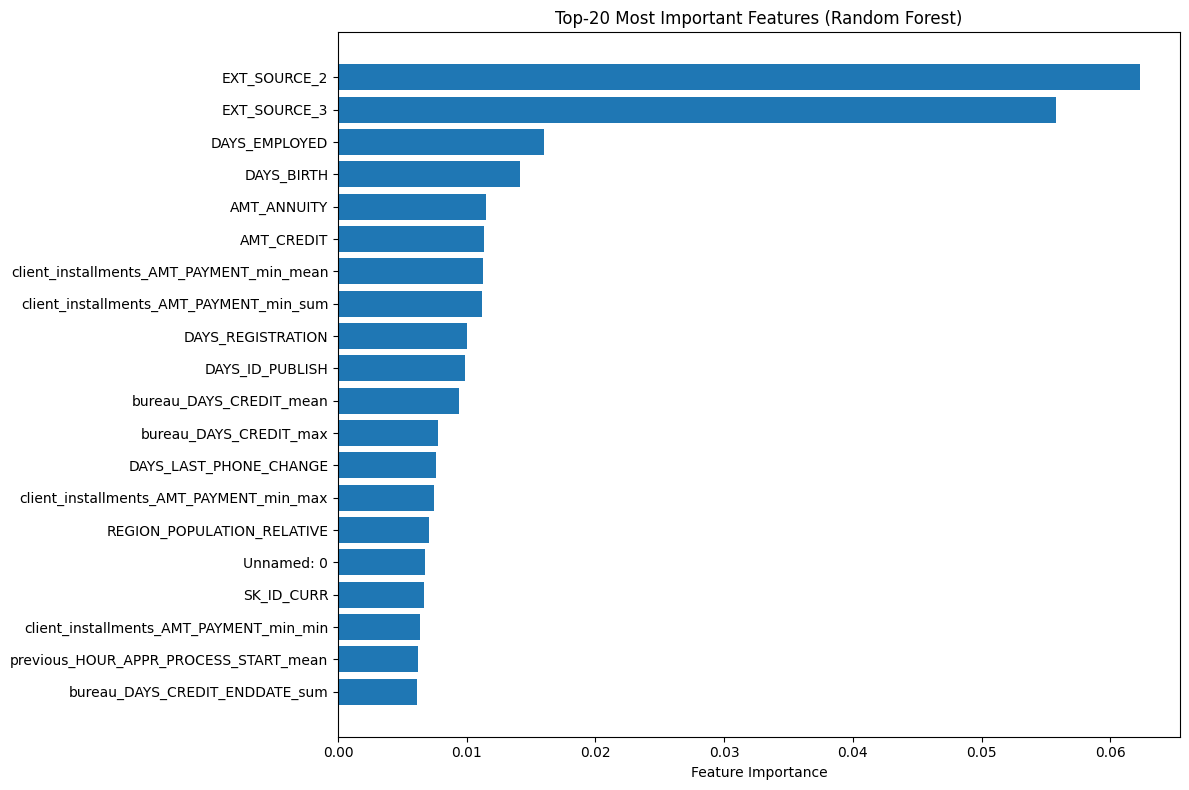


Статистика по важности признаков:
  Всего признаков: 702
  Признаков с importance > 0: 572
  Признаков с importance > 0.01: 9
  Максимальная importance: 0.0623
  Минимальная importance: 0.0000
  Средняя importance: 0.001425

СОХРАНЕНИЕ РЕЗУЛЬТАТОВ ОЦЕНКИ
Полные результаты сохранены в './models/random_forest_best_model.pkl'

ИТОГОВАЯ ИНФОРМАЦИЯ О RANDOM FOREST

Модель: Random Forest Classifier
Лучший CV ROC-AUC: 0.7540
Валидационный ROC-AUC: 0.7524
Accuracy на валидации: 0.9171
F1 Score на валидации: 0.5336

Характеристики леса:
  Количество деревьев: 250
  Глубина деревьев: None
  Признаков на разделение: 0.30000000000000004


In [6]:
print("="*80)
print("БЛОК 3: ОЦЕНКА МЕТРИК RANDOM FOREST НА ВАЛИДАЦИОННОЙ ВЫБОРКЕ")
print("="*80)

from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, f1_score, roc_auc_score,
                           precision_score, recall_score)

# 1. Предсказания на валидационной выборке
print("\n1. Выполнение предсказаний на валидации...")
print(f"   Размер валидационных данных: {X_val.shape}")

# Predict (быстро, т.к. параллельно)
y_val_pred = best_model.predict(X_val)

# Predict_proba для ROC-AUC (тоже быстро)
y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]

print("   Предсказания выполнены!")

# 2. Расчет всех метрик
print("\n2. Расчет метрик...")

accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, average='macro', zero_division=0)
recall = recall_score(y_val, y_val_pred, average='macro', zero_division=0)
f1 = f1_score(y_val, y_val_pred, average='macro', zero_division=0)
roc_auc = roc_auc_score(y_val, y_val_pred_proba)

# 3. Вывод метрик
print("\n" + "="*60)
print("МЕТРИКИ RANDOM FOREST НА ВАЛИДАЦИОННОЙ ВЫБОРКЕ")
print("="*60)

print(f"\nОсновные метрики:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1 Score:  {f1:.4f}")
print(f"  ROC-AUC:   {roc_auc:.4f}")

# 4. Classification Report
print("\n" + "-"*60)
print("Classification Report:")
print("-"*60)
print(classification_report(y_val, y_val_pred, zero_division=0))

# 5. Confusion Matrix
print("\n" + "-"*60)
print("Confusion Matrix:")
print("-"*60)
cm = confusion_matrix(y_val, y_val_pred)
print(cm)

# Визуализация confusion matrix (опционально)
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    print("\nВизуализация Confusion Matrix...")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title('Random Forest Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()
except:
    print("Matplotlib/Seaborn не установлены, пропускаю визуализацию")

# 6. Важность признаков (очень важно для RandomForest!)
print("\n" + "="*60)
print("ВАЖНОСТЬ ПРИЗНАКОВ RANDOM FOREST (TOP-30)")
print("="*60)

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nСамые важные признаки:")
print(feature_importance.head(30).to_string(index=False))

# Визуализация важности признаков (опционально)
try:
    print("\nВизуализация важности признаков (TOP-20)...")
    top_n = 20
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(top_n)
    
    plt.barh(range(top_n), top_features['importance'][::-1])
    plt.yticks(range(top_n), top_features['feature'][::-1])
    plt.xlabel('Feature Importance')
    plt.title(f'Top-{top_n} Most Important Features (Random Forest)')
    plt.tight_layout()
    plt.show()
except:
    print("Пропускаю визуализацию важности признаков")

# Статистика по важности признаков
print(f"\nСтатистика по важности признаков:")
print(f"  Всего признаков: {len(feature_importance)}")
print(f"  Признаков с importance > 0: {(feature_importance['importance'] > 0).sum()}")
print(f"  Признаков с importance > 0.01: {(feature_importance['importance'] > 0.01).sum()}")
print(f"  Максимальная importance: {feature_importance['importance'].max():.4f}")
print(f"  Минимальная importance: {feature_importance['importance'].min():.4f}")
print(f"  Средняя importance: {feature_importance['importance'].mean():.6f}")

# 7. Out-of-Bag оценка (если bootstrap=True)
if hasattr(best_model, 'oob_score_') and best_params.get('bootstrap', True):
    print(f"\n" + "-"*60)
    print("OUT-OF-BAG (OOB) ОЦЕНКА:")
    print("-"*60)
    print(f"  OOB Score: {best_model.oob_score_:.4f}")
    print(f"  OOB Accuracy: {best_model.oob_score_:.4f}")

# 8. Сохранение результатов
print("\n" + "="*60)
print("СОХРАНЕНИЕ РЕЗУЛЬТАТОВ ОЦЕНКИ")
print("="*60)

# Обновляем артефакты с метриками валидации
rf_artifacts['val_metrics'] = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'roc_auc': roc_auc,
    'confusion_matrix': cm.tolist()
}

rf_artifacts['feature_importance'] = feature_importance.to_dict('records')

joblib.dump(rf_artifacts, './models/random_forest_best_model.pkl')
print("Полные результаты сохранены в './models/random_forest_best_model.pkl'")

# 9. Итоговая информация
print("\n" + "="*80)
print("ИТОГОВАЯ ИНФОРМАЦИЯ О RANDOM FOREST")
print("="*80)

print(f"\nМодель: Random Forest Classifier")
print(f"Лучший CV ROC-AUC: {random_search.best_score_:.4f}")
print(f"Валидационный ROC-AUC: {roc_auc:.4f}")
print(f"Accuracy на валидации: {accuracy:.4f}")
print(f"F1 Score на валидации: {f1:.4f}")
print(f"\nХарактеристики леса:")
print(f"  Количество деревьев: {best_model.n_estimators}")
print(f"  Глубина деревьев: {best_model.max_depth}")
print(f"  Признаков на разделение: {best_model.max_features}")

In [13]:

artifacts = joblib.load('./models/random_forest_best_model.pkl')

results = log_model(artifacts['model'], X_val, y_val, 'RandomForestClassifier')
results.to_csv('results.csv', index=False)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 250 out of 250 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s



Добавлена модель: RandomForestClassifier
                 model  accuracy     f1  roc_auc
         SGDClassifier    0.7016 0.5416   0.7617
 DcisionTreeClassifier    0.6481 0.5034   0.7082
RandomForestClassifier    0.9171 0.5336   0.7524


[Parallel(n_jobs=16)]: Done 250 out of 250 | elapsed:    0.3s finished
